# Imports Libraries

In [1]:
import os
import sklearn as sk
import numpy as np
from numpy.random import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import (
    SVC,
)  # SVM is not going to work. After 150.000 samples is almsot impossible to run
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter

# Functions

In [2]:
def crawl_directory(directory: str) -> list:
    """Crawling data directory
    Args:
        directory (str) : The directory to crawl
    Returns:
        tree (list)     : A list with all the filepaths
    """
    tree = []
    subdirs = [folder[0] for folder in os.walk(directory)]

    for subdir in subdirs:
        files = next(os.walk(subdir))[2]
        for _file in files:
            tree.append(os.path.join(subdir, _file))

    return tree

In [3]:
def unique_files(tree: list) -> set:
    """
    Getting the unique file names from a list
    """
    sunolo = set()
    for i in tree:
        sunolo.add(i.split(os.sep)[-1].split(".")[0])
    return sunolo

In [4]:
def load_npys_to_matrics(
    labels: list, videos: list, audio: list, threshold: int = 0.6
) -> tuple:
    """
    Loading the numpy files. Visual and audio will be averaged every 5 and 10 rows respectively.
    DISCLAIMER i keep the minimum number of samples between the same video file from label, video and audio features matrices.
    """
    STATS = {}
    print("Nunpy to Matrices have start")
    files_sizes = []
    labels_matrix = []
    visual_matrix = []
    audio_matrix = []
    if not len(labels) == len(videos) == len(audio):
        raise Exception("Labels, visual features and audio have not the same size")
    for idx in range(len(labels)):
        # load labels, visual and audio in temporary variables
        try:
            tmp_label = np.load(labels[idx])

            # 1 if the timestamp have been annotated at least from the half annotators of that specific file
            max_annotators = int(np.amax(tmp_label))

            if max_annotators < 3:
                continue

            tmp_label[tmp_label / max_annotators < threshold] = 0
            tmp_label[tmp_label / max_annotators >= threshold] = 1

            tmp_label[tmp_label >= max_annotators] = 1

            tmp_visual = np.load(videos[idx])
            tmp_audio = np.load(
                audio[idx]
            ).transpose()  # transposed to the same format of visual features (rows = samplles, columns = features)
            if not max_annotators in STATS.keys():
                STATS[max_annotators] = 0
            STATS[max_annotators] += 1
        except ValueError:
            print(f"File in index {idx} with name {videos[idx]} Not loaded")
            continue

        # get min seconds from the same label, visual, audio np file
        l_r = tmp_label.shape[0]
        v_r, v_c = tmp_visual.shape
        a_r, a_c = tmp_audio.shape

        v_r = v_r // 5
        min_seconds = min(l_r, v_r, a_r)

        files_sizes.append(min_seconds)

        labels_matrix.append(tmp_label[:min_seconds])
        # VISUAL
        # keep number of samples divisible with 5
        tmp_visual = tmp_visual[: min_seconds * 5]
        # averaging visual every 5 (Because we have analyze video with .2 step)
        visual_matrix.append(
            tmp_visual.transpose().reshape(-1, 5).mean(1).reshape(v_c, -1).transpose()
        )

        tmp_audio = tmp_audio[:min_seconds]
        audio_matrix.append(tmp_audio)

        del tmp_label
        del tmp_visual
        del tmp_audio

    # print(STATS)
    return files_sizes, labels_matrix, visual_matrix, audio_matrix

In [5]:
def split(labels: list, videos: list, audio: list, split_size: float) -> tuple:
    if not len(labels) == len(videos) == len(audio):
        raise Exception("Labels, visual features and audio have not the same size")
    if split_size >= 1.0 or split_size <= 0.0:
        raise Exception("Split size is out of bound")
    trainining_size = int(split_size * len(labels))
    # first training, second test
    return (
        np.hstack([label for label in labels[:trainining_size]]),
        np.vstack([video for video in videos[:trainining_size]]),
        np.vstack([audio for audio in audio[:trainining_size]]),
        np.hstack([label for label in labels[trainining_size:]]),
        np.vstack([video for video in videos[trainining_size:]]),
        np.vstack([audio for audio in audio[trainining_size:]]),
    )

In [6]:
def shuffle_lists(labels: list, audio: list, visual: list) -> tuple:
    np.random.seed(47)
    zipped_list = list(zip(labels, audio, visual))
    shuffle(
        zipped_list,
    )
    return zip(*zipped_list)

In [7]:
def grid_search(model, params, param_name, x_train, y_train, x_test, y_test):
    best_score = 0
    for param in params:
        a = {param_name: param}
        model.set_params(**a)
        model.fit(x_train, y_train)
        preds_prob = model.predict_proba(x_test)
        score = roc_auc_score(y_test, preds_prob[:, 1])
        print("{} = {}: {}".format(param_name, param, score))
        # save if best
        if score > best_score:
            best_score = score
            best_param = param
    print("Best score: {}".format(best_score))
    print("Best param: {}".format(best_param))
    return best_param

In [8]:
def read_fuzzy_files(file_path, feature_size=18):
    fuzzy_features = []
    with open(file_path, "r") as _f:
        total = 0
        for line in _f.readlines():
            line = line.rstrip()
            line = line.replace("\x00", "")
            line = line.replace("\t", ",")
            line = line.replace(",,", ",")

            if len(line.split(",")) == feature_size:
                fuzzy_features.append([float(x) for x in line.split(",")])
            else:
                print(f"error on feature size: {len(line.split(','))}")
                #             elif len(line.split(',')) == 61 and line.split(',')[0]=="":
                #                 fuzzy_features.append([float(x) for x  in line.split(',')[1:]])
                #             elif len(line.split(',')) == 61 and line.split(',')[-1]=="":
                #                 fuzzy_features.append([float(x) for x  in line.split(',')[:-1]])
                #             elif len(line.split(',')) == 62:
                #                 fuzzy_features.append([ float(x) for x in line.split(',')[1:-1]])
            total += 1
    print(f"Total: {total}")
    if total != len(fuzzy_features):
        print(total)
        print(len(fuzzy_features))
        print("Error")
    return np.array(fuzzy_features)

In [9]:
def restore_indexes(
    interesting, interesting_indexes, non_interesting, non_interesting_indexes
):
    interesting_fuzzy_features = read_fuzzy_files(interesting, 180)
    interesting_idx = read_indexes(
        interesting_indexes,
    )

    non_interesting_fuzzy_features = read_fuzzy_files(non_interesting, 180)
    non_interesting_idx = read_indexes(non_interesting_indexes)
    interesting = pd.DataFrame(data=interesting_fuzzy_features, index=interesting_idx)
    interesting["label"] = 1
    non_interesting = pd.DataFrame(
        data=non_interesting_fuzzy_features, index=non_interesting_idx
    )
    non_interesting["label"] = 0

    merge = pd.concat([interesting, non_interesting]).sort_index()
    return merge.iloc[:, 0:-1].to_numpy(), merge.iloc[:, -1].to_numpy()

In [10]:
def read_indexes(file):
    with open(file, "r") as f:
        return [int(line.strip()) for line in f.readlines()]

In [11]:
import pandas as pd

In [12]:
import random

random.seed(42)

# Main Logic 

In [13]:
pd.set_option("display.precision", 10)

In [17]:
test_intersting = (
    "new_experiments/experiment_333030/test_intresting_features_333030.txt"
)
test_intersting_indexes = (
    "new_experiments/experiment_333030/test_intresting_indexes_333030.txt"
)
test_non_intersting = (
    "new_experiments/experiment_333030/test_non_intresting_features_333030.txt"
)
test_non_intersting_indexes = (
    "new_experiments/experiment_333030/test_non_intresting_indexes_333030.txt"
)

In [18]:
train_intersting = (
    "new_experiments/experiment_333030/train_intresting_features_333030.txt"
)
train_intersting_indexes = (
    "new_experiments/experiment_333030/train_intresting_indexes_333030.txt"
)
train_non_intersting = (
    "new_experiments/experiment_333030/train_non_intresting_features_333030.txt"
)
train_non_intersting_indexes = (
    "new_experiments/experiment_333030/train_non_intresting_indexes_333030.txt"
)

In [19]:
testing_data, testing_labels = restore_indexes(
    test_intersting,
    test_intersting_indexes,
    test_non_intersting,
    test_non_intersting_indexes,
)

Total: 9366
Total: 21747


In [20]:
training_data, training_labels = restore_indexes(
    train_intersting,
    train_intersting_indexes,
    train_non_intersting,
    train_non_intersting_indexes,
)

Total: 32497
Total: 95475


In [21]:
plots = {}

# Random  Experiment

In [22]:
random_pred_probs = np.random.rand(testing_data.shape[0], 1)

In [23]:
random_pred_probs = np.concatenate((random_pred_probs, 1 - random_pred_probs), axis=1)

In [24]:
random_pred_probs

array([[0.35996232, 0.64003768],
       [0.76321401, 0.23678599],
       [0.53564333, 0.46435667],
       ...,
       [0.81040869, 0.18959131],
       [0.51672693, 0.48327307],
       [0.70616916, 0.29383084]])

In [25]:
random_preds = random_pred_probs.copy()
random_preds[random_preds > 0.5] = 1
random_preds[random_preds <= 0.5] = 0

In [26]:
testing_labels

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
random_preds[:, 1]

array([1., 0., 0., ..., 0., 0., 0.])

In [28]:
print(
    f"Random F1 is: {f1_score(testing_labels, random_preds[:, 1], average='macro') * 100:.2f} %"
)

Random F1 is: 48.25 %


In [29]:
print(
    "ROC AUC score: {}".format(roc_auc_score(testing_labels, random_pred_probs[:, 1]))
)

ROC AUC score: 0.5041526611611739


In [30]:
print(
    f" Confusion Matrix for Random :\n {confusion_matrix(testing_labels, random_preds[:, 1])}"
)

 Confusion Matrix for Random :
 [[10891 10856]
 [ 4617  4749]]


In [31]:
plots["Random"] = roc_curve(testing_labels, random_pred_probs[:, 1])

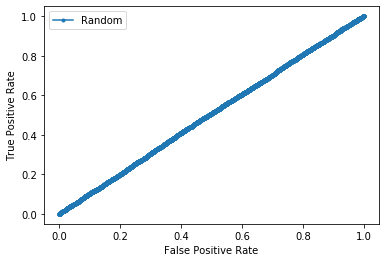

In [32]:
fpr, tpr, _ = roc_curve(testing_labels, random_pred_probs[:, 1])
pyplot.plot(fpr, tpr, marker=".", label="Random")
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Logistic Regression

In [33]:
model = LogisticRegression(solver="lbfgs", max_iter=100000, random_state=42)
C_param_range = {0.001, 0.01, 0.1, 1, 10, 100, 1000}
c = grid_search(
    model,
    C_param_range,
    "C",
    training_data,
    training_labels,
    testing_data,
    testing_labels,
)
fuzzy_lR = LogisticRegression(C=c, solver="lbfgs", max_iter=100000, random_state=42)
fuzzy_lR.fit(training_data, training_labels)
preds = fuzzy_lR.predict(testing_data)
print(
    f"--> F1: Logistic Regression on fuzzy features only  is: {f1_score(testing_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fuzzy_lR.predict_proba(testing_data)
print(
    f"--> ROC AUC: Logistic Regression on fuzzy features only  is: {roc_auc_score(testing_labels, preds_prob[:, 1]) * 100:.2f} %"
)

C = 0.1: 0.6217554622121945
C = 1: 0.6370778365035188
C = 100: 0.6607542020247777
C = 1000: 0.6590157111363995
C = 10: 0.6562796475662144
C = 0.01: 0.614848287187815
C = 0.001: 0.6133610158426941
Best score: 0.6607542020247777
Best param: 100
--> F1: Logistic Regression on fuzzy features only  is: 51.84 %
--> ROC AUC: Logistic Regression on fuzzy features only  is: 66.08 %


### KNN

In [34]:
fuzzy_knn = KNeighborsClassifier(n_neighbors=5)
fuzzy_knn.fit(training_data, training_labels)
preds = fuzzy_knn.predict(testing_data)
print(
    f"--> F1: KNN on fuzzy features only  is: {f1_score(testing_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fuzzy_knn.predict_proba(testing_data)
print(
    f"--> ROC AUC: KNN on fuzzy features only  is: {roc_auc_score(testing_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: KNN on fuzzy features only  is: 54.81 %
--> ROC AUC: KNN on fuzzy features only  is: 60.20 %


## Random Forest

In [35]:
fuzzy_rf = BalancedRandomForestClassifier(
    criterion="gini",
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=42,
)
fuzzy_rf.fit(training_data, training_labels)
preds = fuzzy_rf.predict(testing_data)
print(
    f"--> F1: Random Forest on Audio features only  is: {f1_score(testing_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fuzzy_rf.predict_proba(testing_data)
print(
    f"--> ROC AUC: Random Forest on Audio features only  is: {roc_auc_score(testing_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: Random Forest on Audio features only  is: 57.35 %
--> ROC AUC: Random Forest on Audio features only  is: 66.99 %


In [36]:
import pickle

pickle.dump(fuzzy_rf, open("fuzzy_rf.pt", "wb"))

### Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

fuzzy_nb = GaussianNB()
fuzzy_nb.fit(training_data, training_labels)
preds = fuzzy_nb.predict(testing_data)
print(
    f"--> F1: Bayes on Fuzzy features only  is: {f1_score(testing_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fuzzy_nb.predict_proba(testing_data)
print(
    f"--> ROC AUC: Bayes on Fuzzy features only  is: {roc_auc_score(testing_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: Bayes on Fuzzy features only  is: 55.43 %
--> ROC AUC: Bayes on Fuzzy features only  is: 63.37 %


### Decision Tree

In [38]:
fuzzy_dt = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42)
fuzzy_dt.fit(training_data, training_labels)
preds = fuzzy_dt.predict(testing_data)
print(
    f"--> F1: DT on Audio features only  is: {f1_score(testing_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fuzzy_dt.predict_proba(testing_data)
print(
    f"--> ROC AUC: DT on Audio features only  is: {roc_auc_score(testing_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: DT on Audio features only  is: 51.57 %
--> ROC AUC: DT on Audio features only  is: 61.83 %


### XGBOOST

In [39]:
labels_dist = Counter(training_labels)
imbalance_rate = labels_dist[0] / labels_dist[1]

In [40]:
fuzzy_xgb = XGBClassifier(
    n_estimators=400, scale_pos_weight=imbalance_rate, verbosity=0, seed=42
)
fuzzy_xgb.fit(training_data, training_labels)
preds = fuzzy_xgb.predict(testing_data)
print(
    f"--> F1: XGB on Audio features only  is: {f1_score(testing_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fuzzy_xgb.predict_proba(testing_data)
print(
    f"--> ROC AUC: XGB on Audio features only  is: {roc_auc_score(testing_labels, preds_prob[:, 1]) * 100:.2f} %"
)

/home/theo/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


--> F1: XGB on Audio features only  is: 58.34 %
--> ROC AUC: XGB on Audio features only  is: 64.55 %


In [41]:
pickle.dump(fuzzy_xgb, open("fuzzy_xgb.pt", "wb"))

## Loading CLassifiers

In [42]:
import pickle

fuzzy_rf = pickle.load(open("fuzzy_rf.pt", "rb"))

fuzzy_xgb = pickle.load(open("fuzzy_xgb.pt", "rb"))

### Basic Classification Results

[[11968  9779]
 [ 3053  6313]]


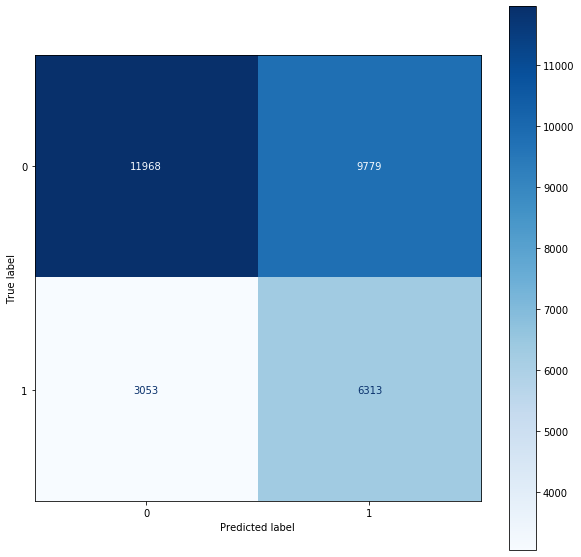

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

classifier = fuzzy_rf
preds = fuzzy_rf.predict(testing_data)

np.set_printoptions(precision=2)
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(
    classifier, testing_data, testing_labels, cmap=plt.cm.Blues, ax=ax
)
# disp.ax_.set_title("Normalized confusion matrix", fontsize=14)
print(disp.confusion_matrix)

plt.savefig("confusion_matrix", dpi=150)
plt.show()

In [44]:
from sklearn.metrics import classification_report

print(classification_report(testing_labels, preds))

              precision    recall  f1-score   support

           0       0.80      0.55      0.65     21747
           1       0.39      0.67      0.50      9366

    accuracy                           0.59     31113
   macro avg       0.59      0.61      0.57     31113
weighted avg       0.68      0.59      0.60     31113



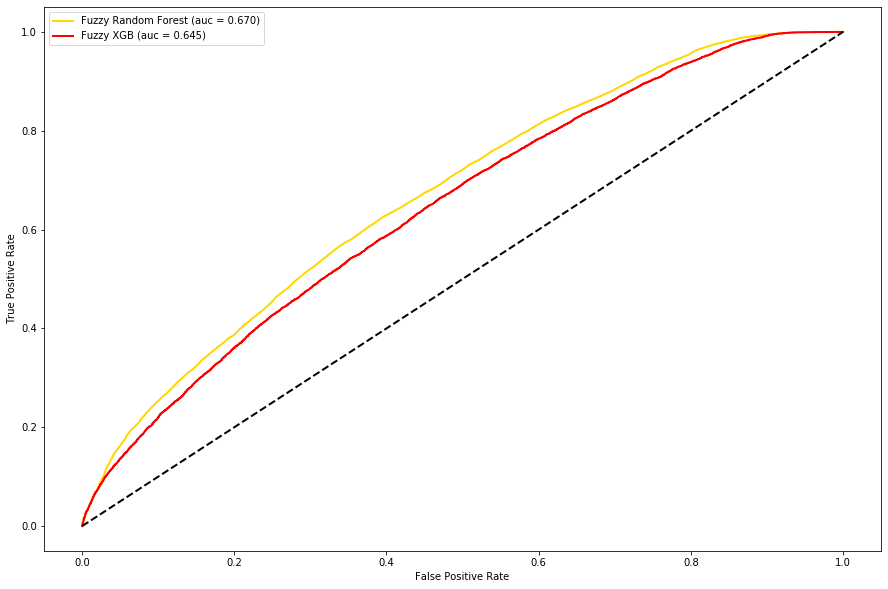

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

plt.figure(figsize=(15, 10))


preds_prob = fuzzy_rf.predict_proba(testing_data)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
plt.plot(
    fpr,
    tpr,
    color="gold",
    lw=2,
    label="Fuzzy Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = fuzzy_xgb.predict_proba(testing_data)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
plt.plot(fpr, tpr, color="red", lw=2, label="Fuzzy XGB (auc = %0.3f)" % auc(fpr, tpr))


plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC curve of the Random Forest classifier applied on the test set", fontsize=14)
plt.legend()
plt.savefig("roc_all", dpi=150)
plt.show()

NameError: name 'fuzzy_model' is not defined

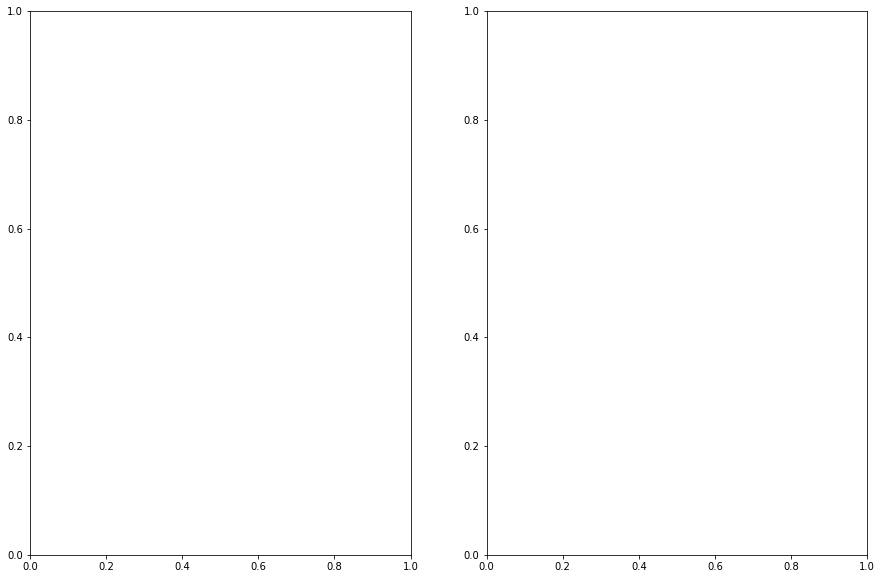

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))


preds_prob = fuzzy_model.predict_proba(testing_data)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
ax1.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="Fused Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = visual_model.predict_proba(test_visual)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
ax1.plot(
    fpr,
    tpr,
    color="darkgreen",
    lw=2,
    label="Visual Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = fuzzy_rf.predict_proba(testing_data)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
ax1.plot(
    fpr,
    tpr,
    color="brown",
    lw=2,
    label="Audio Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")


preds_prob = fusion_xgb.predict_proba(testing_data)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
ax2.plot(
    fpr, tpr, color="darkorange", lw=2, label="Fused XGB (auc = %0.3f)" % auc(fpr, tpr)
)

preds_prob = visual_xgb.predict_proba(test_visual)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
ax2.plot(
    fpr, tpr, color="darkgreen", lw=2, label="Visual XGB (auc = %0.3f)" % auc(fpr, tpr)
)

preds_prob = fuzzy_xgb.predict_proba(testing_data)
fpr, tpr, _ = roc_curve(testing_labels, preds_prob[:, 1])
ax2.plot(fpr, tpr, color="brown", lw=2, label="Audio XGB (auc = %0.3f)" % auc(fpr, tpr))


ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Random Forest")

ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("XGBoost")
# plt.title("ROC curve of the Random Forest classifier applied on the test set", fontsize=14)
ax1.legend()
ax2.legend()
plt.savefig("roc_separate", dpi=150)
plt.show()

### Post Processing

In [ ]:
from scipy.signal import medfilt


def smoothing(predicted, med_thres=5, hard_thres=3):
    """
    Filtering Predictions
    """
    data = predicted.copy()
    data = medfilt(data, med_thres)
    count = 0
    start = -1
    length = len(predicted)
    for idx, item in enumerate(data):
        if item == 1:
            count += 1
            if start == -1:
                start = idx
            if count < hard_thres:
                if idx == length - 1:
                    return data
                elif data[idx + 1] == 0:
                    count = 0
                    data[start : idx + 1] = 0
        if item == 0:
            start = -1
            count = 0
    return data

In [ ]:
thresholds = [3, 5]
pres = {}
recs = {}
f1 = {}
acc = {}
for threshold in thresholds:
    preds_thres = smoothing(preds, 3, threshold)
    pre = precision_score(testing_labels, preds_thres)
    pres[threshold] = 100 * pre
    rec = recall_score(testing_labels, preds_thres)
    recs[threshold] = 100 * rec
    f1[threshold] = 100 * f1_score(testing_labels, preds_thres, average="macro")
    acc[threshold] = 100 * accuracy_score(testing_labels, preds_thres)

In [ ]:
print(pres)

In [ ]:
print(recs)

In [ ]:
print(f1)

In [ ]:
print(acc)

In [ ]:
f1_score(testing_labels, preds, average="macro")

## Video Level Testing

In [ ]:
trainining_size = int(0.8 * len(labels_matrix))

video_labels = labels_matrix[trainining_size:]
video_test = [
    np.hstack((visual, audio))
    for visual, audio in zip(
        visual_matrix[trainining_size:], audio_matrix[trainining_size:]
    )
]

In [ ]:
model = fuzzy_model
pres = []
recs = []
for features, labels in zip(video_test, video_labels):
    preds = model.predict(features)
    preds = smoothing(preds, 3, 5)
    pre = precision_score(labels, preds)
    pres.append(100 * pre)
    rec = recall_score(labels, preds)
    recs.append(100 * rec)

In [ ]:
import scipy.stats as st
import matplotlib.pyplot as plt

x = pres
plt.figure(figsize=(10, 10))
plt.hist(x, density=True)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs))
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.ylabel("Frequency")
plt.xlabel("Video level precision (macro average %)")
plt.savefig("precision_hist", dpi=150)

In [ ]:
import scipy.stats as st
import matplotlib.pyplot as plt

x = recs
plt.figure(figsize=(10, 10))
plt.hist(x, density=True)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs))
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.ylabel("Frequency")
plt.xlabel("Video level recall (macro average %)")
plt.savefig("recall_hist", dpi=150)
plt.show()

In [ ]:
def video_level_accuracy(model, labels_list, features_list, acc_thres=0.85):
    cnt = 0
    for features, labels in zip(features_list, labels_list):
        preds = model.predict(features)
        preds = smoothing(preds, 3, 5)
        acc = accuracy_score(labels, preds)
        if acc >= acc_thres:
            cnt += 1
    return cnt / len(labels_list)

In [ ]:
model = fuzzy_model
accuracy = video_level_accuracy(model, video_labels, video_test, acc_thres=0.6)
print(f"--> Video level accuracy of the best classifier if: {accuracy * 100:.2f} %")